# HW3 Image Classification
## We strongly recommend that you run with [Kaggle](https://www.kaggle.com/t/86ca241732c04da99aca6490080bae73) for this homework

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

# Check GPU Type

In [ ]:
!nvidia-smi

Mon Mar 13 14:55:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    31W /  70W |    625MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [ ]:
# Download Link
# Link 1 (Dropbox): https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
# Link 2 (Google Drive): https://drive.google.com/file/d/1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9/view?usp=share_link
# Link 3: Kaggle Competition.

# (1) dropbox link
# !wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0

# (2) google drive link
# !pip install gdown --upgrade
# !gdown --id '1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9' --output food11.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9
To: /content/food11.zip
100% 1.16G/1.16G [00:09<00:00, 126MB/s] 


In [ ]:
! unzip food11.zip

Archive:  food11.zip
replace valid/9_2898.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Import Packages

In [1]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import StepLR

In [2]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data *wrapping* as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [3]:
# TODO: 尝试使用多种data augmentation的方法
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [4]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files

        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)

        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label

        return im,label

# Model

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Configurations

In [6]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of batch size.
batch_size = 64

# The number of training epochs.
n_epochs = 8

# If no improvement in 'patience' epochs, early stop.
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Dataloader

In [7]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("./oscl_datasets/train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./oscl_datasets/valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Trainer

In [8]:
def train(model, n_epochs, train_loader, valid_loader, device, criterion, optimizer, lr_scheduler=None, exp_name='sample', patience=5):
    stale = 0
    best_acc = 0
    for epoch in range(n_epochs):
        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()
            #print(imgs.shape,labels.shape)

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)
            #break

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


        # update logs
        if valid_acc > best_acc:
            with open(f"./{exp_name}_log.txt","a"):
                print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
        else:
            with open(f"./{exp_name}_log.txt","a"):
                print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

        if lr_scheduler:
            lr_scheduler.step()
            
        # save models
        if valid_acc > best_acc:
            print(f"Best model found at epoch {epoch}, saving model")
            torch.save(model.state_dict(), f"{exp_name}_best.ckpt") # only save best to prevent output memory exceed error
            best_acc = valid_acc
            stale = 0
        else:
            stale += 1
            if patience > 0 and stale > patience:
                print(f"No improvment {patience} consecutive epochs, early stopping")
                break

# Training Models

In [13]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
model = Classifier().to(device)
# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
train_set = FoodDataset("./oscl_datasets/train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./oscl_datasets/valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
train(model, 10, train_loader, valid_loader, device, criterion, optimizer, exp_name='simple')

  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 001/020 ] loss = 1.89408, acc = 0.33698


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 001/020 ] loss = 1.73273, acc = 0.40304
[ Valid | 001/020 ] loss = 1.73273, acc = 0.40304 -> best
Best model found at epoch 0, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 002/020 ] loss = 1.52779, acc = 0.47442


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 002/020 ] loss = 1.64163, acc = 0.42961
[ Valid | 002/020 ] loss = 1.64163, acc = 0.42961 -> best
Best model found at epoch 1, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 003/020 ] loss = 1.31567, acc = 0.55225


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 003/020 ] loss = 1.51322, acc = 0.47408
[ Valid | 003/020 ] loss = 1.51322, acc = 0.47408 -> best
Best model found at epoch 2, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 004/020 ] loss = 1.14834, acc = 0.60529


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 004/020 ] loss = 1.45106, acc = 0.51308
[ Valid | 004/020 ] loss = 1.45106, acc = 0.51308 -> best
Best model found at epoch 3, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 005/020 ] loss = 1.00623, acc = 0.65237


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 005/020 ] loss = 1.35855, acc = 0.54947
[ Valid | 005/020 ] loss = 1.35855, acc = 0.54947 -> best
Best model found at epoch 4, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 006/020 ] loss = 0.89157, acc = 0.69198


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 006/020 ] loss = 1.18813, acc = 0.60692
[ Valid | 006/020 ] loss = 1.18813, acc = 0.60692 -> best
Best model found at epoch 5, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 007/020 ] loss = 0.76171, acc = 0.73447


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 007/020 ] loss = 1.36070, acc = 0.56660
[ Valid | 007/020 ] loss = 1.36070, acc = 0.56660


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 008/020 ] loss = 0.63648, acc = 0.78384


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 008/020 ] loss = 1.28587, acc = 0.58586
[ Valid | 008/020 ] loss = 1.28587, acc = 0.58586


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 009/020 ] loss = 0.54663, acc = 0.81051


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 009/020 ] loss = 1.50847, acc = 0.57903
[ Valid | 009/020 ] loss = 1.50847, acc = 0.57903


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 010/020 ] loss = 0.45009, acc = 0.84116


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 010/020 ] loss = 1.30511, acc = 0.62276
[ Valid | 010/020 ] loss = 1.30511, acc = 0.62276 -> best
Best model found at epoch 9, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 011/020 ] loss = 0.36654, acc = 0.87450


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 011/020 ] loss = 1.44000, acc = 0.62175
[ Valid | 011/020 ] loss = 1.44000, acc = 0.62175


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 012/020 ] loss = 0.27944, acc = 0.90695


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 012/020 ] loss = 1.34854, acc = 0.63838
[ Valid | 012/020 ] loss = 1.34854, acc = 0.63838 -> best
Best model found at epoch 11, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 013/020 ] loss = 0.21544, acc = 0.92546


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 013/020 ] loss = 1.58136, acc = 0.63288
[ Valid | 013/020 ] loss = 1.58136, acc = 0.63288


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 014/020 ] loss = 0.18294, acc = 0.93501


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 014/020 ] loss = 1.56778, acc = 0.63089
[ Valid | 014/020 ] loss = 1.56778, acc = 0.63089


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 015/020 ] loss = 0.13597, acc = 0.95303


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 015/020 ] loss = 1.91347, acc = 0.62709
[ Valid | 015/020 ] loss = 1.91347, acc = 0.62709


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 016/020 ] loss = 0.11385, acc = 0.96029


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 016/020 ] loss = 1.73079, acc = 0.63593
[ Valid | 016/020 ] loss = 1.73079, acc = 0.63593


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 017/020 ] loss = 0.09312, acc = 0.96805


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 017/020 ] loss = 1.94104, acc = 0.61620
[ Valid | 017/020 ] loss = 1.94104, acc = 0.61620


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 018/020 ] loss = 0.07828, acc = 0.97373


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 018/020 ] loss = 2.21735, acc = 0.61131
[ Valid | 018/020 ] loss = 2.21735, acc = 0.61131
No improvment 5 consecutive epochs, early stopping


# Dataloader for test

In [9]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("./oscl_datasets/test", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Testing and generate prediction CSV

In [ ]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"sample_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

In [ ]:
# create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice.
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


#### Medium Baseline (Acc=0.700)

do some data augmentation & train longer

In [10]:
new_train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop((128, 128), scale=(0.5, 1)),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

In [18]:
model = Classifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
train_set = FoodDataset("./oscl_datasets/train", tfm=new_train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./oscl_datasets/valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

train(model, 50, train_loader, valid_loader, device, criterion, optimizer, exp_name='medium')

In [22]:
def get_dataloader(root='./oscl_datasets'):
    train_set = FoodDataset(os.path.join(root, "train"), tfm=new_train_tfm)
    valid_set = FoodDataset(os.path.join(root, "valid"), tfm=test_tfm)
    # Repartition the dataset
    train_set.files.extend(valid_set.files[:2000])
    valid_set.files = valid_set.files[2000:]
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    return train_loader, valid_loader

#### Strong Baseline (Acc=0.814)

use predefined CNN model from torchvision or timm

In [21]:
# use timm
import timm
from torch.optim.lr_scheduler import StepLR

resnet = timm.create_model('resnet101', pretrained=False, num_classes=11).to(device)

In [23]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001, weight_decay=1e-5)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
train_loader, valid_loader = get_dataloader()
train(resnet, 100, train_loader, valid_loader, device, criterion, optimizer, lr_scheduler=lr_scheduler, exp_name='strong_resnet', patience=-1)

  0%|          | 0/188 [00:00<?, ?it/s]

100%|██████████| 188/188 [02:35<00:00,  1.21it/s]


[ Train | 001/100 ] loss = 1.94232, acc = 0.32887


100%|██████████| 26/26 [00:15<00:00,  1.72it/s]


[ Valid | 001/100 ] loss = 2.30616, acc = 0.16911
[ Valid | 001/100 ] loss = 2.30616, acc = 0.16911 -> best
Best model found at epoch 0, saving model


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 002/100 ] loss = 1.76246, acc = 0.39195


100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


[ Valid | 002/100 ] loss = 1.92374, acc = 0.34518
[ Valid | 002/100 ] loss = 1.92374, acc = 0.34518 -> best
Best model found at epoch 1, saving model


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 003/100 ] loss = 1.62335, acc = 0.44041


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 003/100 ] loss = 2.36072, acc = 0.21358
[ Valid | 003/100 ] loss = 2.36072, acc = 0.21358


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 004/100 ] loss = 1.53048, acc = 0.47897


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 004/100 ] loss = 1.93093, acc = 0.35268
[ Valid | 004/100 ] loss = 1.93093, acc = 0.35268 -> best
Best model found at epoch 3, saving model


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 005/100 ] loss = 1.44736, acc = 0.50474


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 005/100 ] loss = 1.91021, acc = 0.36674
[ Valid | 005/100 ] loss = 1.91021, acc = 0.36674 -> best
Best model found at epoch 4, saving model


100%|██████████| 188/188 [01:03<00:00,  2.98it/s]


[ Train | 006/100 ] loss = 1.36501, acc = 0.53707


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 006/100 ] loss = 1.77677, acc = 0.37907
[ Valid | 006/100 ] loss = 1.77677, acc = 0.37907 -> best
Best model found at epoch 5, saving model


100%|██████████| 188/188 [01:03<00:00,  2.98it/s]


[ Train | 007/100 ] loss = 1.30596, acc = 0.55452


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 007/100 ] loss = 2.05791, acc = 0.32172
[ Valid | 007/100 ] loss = 2.05791, acc = 0.32172


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 008/100 ] loss = 1.25111, acc = 0.57131


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 008/100 ] loss = 1.91906, acc = 0.38299
[ Valid | 008/100 ] loss = 1.91906, acc = 0.38299 -> best
Best model found at epoch 7, saving model


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 009/100 ] loss = 1.18495, acc = 0.59441


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 009/100 ] loss = 1.48033, acc = 0.49263
[ Valid | 009/100 ] loss = 1.48033, acc = 0.49263 -> best
Best model found at epoch 8, saving model


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 010/100 ] loss = 1.14305, acc = 0.61478


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 010/100 ] loss = 1.78452, acc = 0.39828
[ Valid | 010/100 ] loss = 1.78452, acc = 0.39828


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 011/100 ] loss = 1.01343, acc = 0.65417


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 011/100 ] loss = 1.88399, acc = 0.40520
[ Valid | 011/100 ] loss = 1.88399, acc = 0.40520


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 012/100 ] loss = 0.96405, acc = 0.66755


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


[ Valid | 012/100 ] loss = 1.33856, acc = 0.54435
[ Valid | 012/100 ] loss = 1.33856, acc = 0.54435 -> best
Best model found at epoch 11, saving model


100%|██████████| 188/188 [01:04<00:00,  2.94it/s]


[ Train | 013/100 ] loss = 0.93560, acc = 0.67927


100%|██████████| 26/26 [00:06<00:00,  4.07it/s]


[ Valid | 013/100 ] loss = 1.38492, acc = 0.55722
[ Valid | 013/100 ] loss = 1.38492, acc = 0.55722 -> best
Best model found at epoch 12, saving model


100%|██████████| 188/188 [02:20<00:00,  1.34it/s]


[ Train | 014/100 ] loss = 0.90213, acc = 0.69049


100%|██████████| 26/26 [00:12<00:00,  2.01it/s]


[ Valid | 014/100 ] loss = 1.25247, acc = 0.57947
[ Valid | 014/100 ] loss = 1.25247, acc = 0.57947 -> best
Best model found at epoch 13, saving model


100%|██████████| 188/188 [01:34<00:00,  1.99it/s]


[ Train | 015/100 ] loss = 0.88649, acc = 0.69631


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 015/100 ] loss = 1.31673, acc = 0.55903
[ Valid | 015/100 ] loss = 1.31673, acc = 0.55903


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 016/100 ] loss = 0.85563, acc = 0.70745


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 016/100 ] loss = 1.21074, acc = 0.59452
[ Valid | 016/100 ] loss = 1.21074, acc = 0.59452 -> best
Best model found at epoch 15, saving model


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 017/100 ] loss = 0.84275, acc = 0.71293


100%|██████████| 26/26 [00:05<00:00,  4.38it/s]


[ Valid | 017/100 ] loss = 1.33325, acc = 0.59927
[ Valid | 017/100 ] loss = 1.33325, acc = 0.59927 -> best
Best model found at epoch 16, saving model


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 018/100 ] loss = 0.81858, acc = 0.72199


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 018/100 ] loss = 1.11946, acc = 0.61312
[ Valid | 018/100 ] loss = 1.11946, acc = 0.61312 -> best
Best model found at epoch 17, saving model


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 019/100 ] loss = 0.79859, acc = 0.73246


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


[ Valid | 019/100 ] loss = 1.42073, acc = 0.54762
[ Valid | 019/100 ] loss = 1.42073, acc = 0.54762


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 020/100 ] loss = 0.77871, acc = 0.73496


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 020/100 ] loss = 1.17876, acc = 0.60773
[ Valid | 020/100 ] loss = 1.17876, acc = 0.60773


100%|██████████| 188/188 [01:03<00:00,  2.98it/s]


[ Train | 021/100 ] loss = 0.68627, acc = 0.76247


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 021/100 ] loss = 0.98306, acc = 0.65758
[ Valid | 021/100 ] loss = 0.98306, acc = 0.65758 -> best
Best model found at epoch 20, saving model


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 022/100 ] loss = 0.65970, acc = 0.77385


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 022/100 ] loss = 1.34561, acc = 0.57437
[ Valid | 022/100 ] loss = 1.34561, acc = 0.57437


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 023/100 ] loss = 0.63493, acc = 0.78300


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 023/100 ] loss = 1.23544, acc = 0.60953
[ Valid | 023/100 ] loss = 1.23544, acc = 0.60953


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 024/100 ] loss = 0.61891, acc = 0.78474


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 024/100 ] loss = 1.09693, acc = 0.62332
[ Valid | 024/100 ] loss = 1.09693, acc = 0.62332


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 025/100 ] loss = 0.59375, acc = 0.79654


100%|██████████| 26/26 [00:05<00:00,  4.35it/s]


[ Valid | 025/100 ] loss = 1.19016, acc = 0.61041
[ Valid | 025/100 ] loss = 1.19016, acc = 0.61041


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 026/100 ] loss = 0.58884, acc = 0.79787


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 026/100 ] loss = 1.35955, acc = 0.59566
[ Valid | 026/100 ] loss = 1.35955, acc = 0.59566


100%|██████████| 188/188 [01:03<00:00,  2.98it/s]


[ Train | 027/100 ] loss = 0.56035, acc = 0.80485


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 027/100 ] loss = 1.07535, acc = 0.66205
[ Valid | 027/100 ] loss = 1.07535, acc = 0.66205 -> best
Best model found at epoch 26, saving model


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 028/100 ] loss = 0.55720, acc = 0.80760


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 028/100 ] loss = 1.02885, acc = 0.66478
[ Valid | 028/100 ] loss = 1.02885, acc = 0.66478 -> best
Best model found at epoch 27, saving model


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 029/100 ] loss = 0.53032, acc = 0.81707


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 029/100 ] loss = 1.22451, acc = 0.61192
[ Valid | 029/100 ] loss = 1.22451, acc = 0.61192


100%|██████████| 188/188 [01:03<00:00,  2.98it/s]


[ Train | 030/100 ] loss = 0.51840, acc = 0.82256


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


[ Valid | 030/100 ] loss = 1.06070, acc = 0.67165
[ Valid | 030/100 ] loss = 1.06070, acc = 0.67165 -> best
Best model found at epoch 29, saving model


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 031/100 ] loss = 0.46228, acc = 0.84250


100%|██████████| 26/26 [00:05<00:00,  4.35it/s]


[ Valid | 031/100 ] loss = 1.05329, acc = 0.67737
[ Valid | 031/100 ] loss = 1.05329, acc = 0.67737 -> best
Best model found at epoch 30, saving model


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 032/100 ] loss = 0.44338, acc = 0.84824


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 032/100 ] loss = 1.02172, acc = 0.67974
[ Valid | 032/100 ] loss = 1.02172, acc = 0.67974 -> best
Best model found at epoch 31, saving model


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 033/100 ] loss = 0.42548, acc = 0.85414


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 033/100 ] loss = 1.02279, acc = 0.69060
[ Valid | 033/100 ] loss = 1.02279, acc = 0.69060 -> best
Best model found at epoch 32, saving model


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 034/100 ] loss = 0.40758, acc = 0.86004


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 034/100 ] loss = 1.06923, acc = 0.66416
[ Valid | 034/100 ] loss = 1.06923, acc = 0.66416


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 035/100 ] loss = 0.39877, acc = 0.86228


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 035/100 ] loss = 1.11036, acc = 0.67165
[ Valid | 035/100 ] loss = 1.11036, acc = 0.67165


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 036/100 ] loss = 0.39189, acc = 0.86469


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


[ Valid | 036/100 ] loss = 1.05194, acc = 0.67554
[ Valid | 036/100 ] loss = 1.05194, acc = 0.67554


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 037/100 ] loss = 0.38756, acc = 0.86885


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 037/100 ] loss = 1.09809, acc = 0.67797
[ Valid | 037/100 ] loss = 1.09809, acc = 0.67797


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 038/100 ] loss = 0.37067, acc = 0.87292


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 038/100 ] loss = 1.21076, acc = 0.64795
[ Valid | 038/100 ] loss = 1.21076, acc = 0.64795


100%|██████████| 188/188 [01:03<00:00,  2.98it/s]


[ Train | 039/100 ] loss = 0.35784, acc = 0.87566


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 039/100 ] loss = 1.02370, acc = 0.69270
[ Valid | 039/100 ] loss = 1.02370, acc = 0.69270 -> best
Best model found at epoch 38, saving model


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 040/100 ] loss = 0.35154, acc = 0.88215


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 040/100 ] loss = 1.30275, acc = 0.63773
[ Valid | 040/100 ] loss = 1.30275, acc = 0.63773


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 041/100 ] loss = 0.30140, acc = 0.89702


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


[ Valid | 041/100 ] loss = 1.09612, acc = 0.68760
[ Valid | 041/100 ] loss = 1.09612, acc = 0.68760


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 042/100 ] loss = 0.30233, acc = 0.89370


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 042/100 ] loss = 1.10509, acc = 0.69333
[ Valid | 042/100 ] loss = 1.10509, acc = 0.69333 -> best
Best model found at epoch 41, saving model


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 043/100 ] loss = 0.28551, acc = 0.90401


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 043/100 ] loss = 1.01009, acc = 0.70681
[ Valid | 043/100 ] loss = 1.01009, acc = 0.70681 -> best
Best model found at epoch 42, saving model


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 044/100 ] loss = 0.28751, acc = 0.90384


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 044/100 ] loss = 1.04793, acc = 0.70171
[ Valid | 044/100 ] loss = 1.04793, acc = 0.70171


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 045/100 ] loss = 0.27219, acc = 0.90766


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


[ Valid | 045/100 ] loss = 1.14119, acc = 0.68581
[ Valid | 045/100 ] loss = 1.14119, acc = 0.68581


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 046/100 ] loss = 0.26330, acc = 0.91157


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


[ Valid | 046/100 ] loss = 1.12828, acc = 0.67440
[ Valid | 046/100 ] loss = 1.12828, acc = 0.67440


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 047/100 ] loss = 0.24430, acc = 0.91714


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


[ Valid | 047/100 ] loss = 1.06870, acc = 0.70951
[ Valid | 047/100 ] loss = 1.06870, acc = 0.70951 -> best
Best model found at epoch 46, saving model


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 048/100 ] loss = 0.25376, acc = 0.91423


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 048/100 ] loss = 1.10663, acc = 0.70352
[ Valid | 048/100 ] loss = 1.10663, acc = 0.70352


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 049/100 ] loss = 0.24532, acc = 0.91622


100%|██████████| 26/26 [00:05<00:00,  4.33it/s]


[ Valid | 049/100 ] loss = 1.16127, acc = 0.68698
[ Valid | 049/100 ] loss = 1.16127, acc = 0.68698


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 050/100 ] loss = 0.24102, acc = 0.91714


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 050/100 ] loss = 1.16463, acc = 0.69453
[ Valid | 050/100 ] loss = 1.16463, acc = 0.69453


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 051/100 ] loss = 0.21263, acc = 0.92570


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 051/100 ] loss = 1.12559, acc = 0.69720
[ Valid | 051/100 ] loss = 1.12559, acc = 0.69720


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 052/100 ] loss = 0.21178, acc = 0.92686


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


[ Valid | 052/100 ] loss = 1.11143, acc = 0.71375
[ Valid | 052/100 ] loss = 1.11143, acc = 0.71375 -> best
Best model found at epoch 51, saving model


100%|██████████| 188/188 [01:04<00:00,  2.93it/s]


[ Train | 053/100 ] loss = 0.20725, acc = 0.93251


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 053/100 ] loss = 1.21588, acc = 0.68609
[ Valid | 053/100 ] loss = 1.21588, acc = 0.68609


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 054/100 ] loss = 0.20779, acc = 0.92911


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 054/100 ] loss = 1.25530, acc = 0.68640
[ Valid | 054/100 ] loss = 1.25530, acc = 0.68640


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 055/100 ] loss = 0.19746, acc = 0.93002


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 055/100 ] loss = 1.13988, acc = 0.70680
[ Valid | 055/100 ] loss = 1.13988, acc = 0.70680


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 056/100 ] loss = 0.19701, acc = 0.93334


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 056/100 ] loss = 1.19192, acc = 0.69329
[ Valid | 056/100 ] loss = 1.19192, acc = 0.69329


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 057/100 ] loss = 0.19301, acc = 0.93260


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 057/100 ] loss = 1.15135, acc = 0.70504
[ Valid | 057/100 ] loss = 1.15135, acc = 0.70504


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 058/100 ] loss = 0.18764, acc = 0.93758


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 058/100 ] loss = 1.19752, acc = 0.69960
[ Valid | 058/100 ] loss = 1.19752, acc = 0.69960


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 059/100 ] loss = 0.18863, acc = 0.93517


100%|██████████| 26/26 [00:05<00:00,  4.35it/s]


[ Valid | 059/100 ] loss = 1.21621, acc = 0.69992
[ Valid | 059/100 ] loss = 1.21621, acc = 0.69992


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 060/100 ] loss = 0.18514, acc = 0.93625


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 060/100 ] loss = 1.23851, acc = 0.69213
[ Valid | 060/100 ] loss = 1.23851, acc = 0.69213


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 061/100 ] loss = 0.17713, acc = 0.94074


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


[ Valid | 061/100 ] loss = 1.19746, acc = 0.70173
[ Valid | 061/100 ] loss = 1.19746, acc = 0.70173


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 062/100 ] loss = 0.17998, acc = 0.93758


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


[ Valid | 062/100 ] loss = 1.19921, acc = 0.70352
[ Valid | 062/100 ] loss = 1.19921, acc = 0.70352


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 063/100 ] loss = 0.16746, acc = 0.94382


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 063/100 ] loss = 1.23026, acc = 0.69871
[ Valid | 063/100 ] loss = 1.23026, acc = 0.69871


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 064/100 ] loss = 0.15959, acc = 0.94722


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 064/100 ] loss = 1.22054, acc = 0.69777
[ Valid | 064/100 ] loss = 1.22054, acc = 0.69777


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 065/100 ] loss = 0.16671, acc = 0.94132


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


[ Valid | 065/100 ] loss = 1.20385, acc = 0.71370
[ Valid | 065/100 ] loss = 1.20385, acc = 0.71370


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 066/100 ] loss = 0.16405, acc = 0.94274


100%|██████████| 26/26 [00:05<00:00,  4.38it/s]


[ Valid | 066/100 ] loss = 1.24060, acc = 0.70473
[ Valid | 066/100 ] loss = 1.24060, acc = 0.70473


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 067/100 ] loss = 0.16276, acc = 0.94573


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 067/100 ] loss = 1.21037, acc = 0.70772
[ Valid | 067/100 ] loss = 1.21037, acc = 0.70772


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 068/100 ] loss = 0.15870, acc = 0.94814


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


[ Valid | 068/100 ] loss = 1.32049, acc = 0.69211
[ Valid | 068/100 ] loss = 1.32049, acc = 0.69211


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 069/100 ] loss = 0.15734, acc = 0.94764


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 069/100 ] loss = 1.24131, acc = 0.70652
[ Valid | 069/100 ] loss = 1.24131, acc = 0.70652


100%|██████████| 188/188 [01:03<00:00,  2.98it/s]


[ Train | 070/100 ] loss = 0.15638, acc = 0.94589


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 070/100 ] loss = 1.27929, acc = 0.69630
[ Valid | 070/100 ] loss = 1.27929, acc = 0.69630


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 071/100 ] loss = 0.14565, acc = 0.95121


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 071/100 ] loss = 1.29002, acc = 0.70201
[ Valid | 071/100 ] loss = 1.29002, acc = 0.70201


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 072/100 ] loss = 0.15386, acc = 0.94731


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 072/100 ] loss = 1.28206, acc = 0.69390
[ Valid | 072/100 ] loss = 1.28206, acc = 0.69390


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 073/100 ] loss = 0.15176, acc = 0.94988


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 073/100 ] loss = 1.27472, acc = 0.70561
[ Valid | 073/100 ] loss = 1.27472, acc = 0.70561


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 074/100 ] loss = 0.14897, acc = 0.95113


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 074/100 ] loss = 1.26032, acc = 0.70866
[ Valid | 074/100 ] loss = 1.26032, acc = 0.70866


100%|██████████| 188/188 [01:03<00:00,  2.98it/s]


[ Train | 075/100 ] loss = 0.14198, acc = 0.95188


100%|██████████| 26/26 [00:05<00:00,  4.36it/s]


[ Valid | 075/100 ] loss = 1.19813, acc = 0.72212
[ Valid | 075/100 ] loss = 1.19813, acc = 0.72212 -> best
Best model found at epoch 74, saving model


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 076/100 ] loss = 0.15466, acc = 0.94689


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 076/100 ] loss = 1.27948, acc = 0.69962
[ Valid | 076/100 ] loss = 1.27948, acc = 0.69962


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 077/100 ] loss = 0.14717, acc = 0.95196


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 077/100 ] loss = 1.27124, acc = 0.69538
[ Valid | 077/100 ] loss = 1.27124, acc = 0.69538


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 078/100 ] loss = 0.14899, acc = 0.94897


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 078/100 ] loss = 1.25665, acc = 0.70353
[ Valid | 078/100 ] loss = 1.25665, acc = 0.70353


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 079/100 ] loss = 0.15425, acc = 0.94930


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 079/100 ] loss = 1.27990, acc = 0.69963
[ Valid | 079/100 ] loss = 1.27990, acc = 0.69963


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 080/100 ] loss = 0.14784, acc = 0.95030


100%|██████████| 26/26 [00:05<00:00,  4.36it/s]


[ Valid | 080/100 ] loss = 1.25559, acc = 0.70649
[ Valid | 080/100 ] loss = 1.25559, acc = 0.70649


100%|██████████| 188/188 [01:05<00:00,  2.86it/s]


[ Train | 081/100 ] loss = 0.14825, acc = 0.94914


100%|██████████| 26/26 [00:07<00:00,  3.54it/s]


[ Valid | 081/100 ] loss = 1.29768, acc = 0.70081
[ Valid | 081/100 ] loss = 1.29768, acc = 0.70081


100%|██████████| 188/188 [01:17<00:00,  2.44it/s]


[ Train | 082/100 ] loss = 0.14380, acc = 0.95171


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


[ Valid | 082/100 ] loss = 1.35334, acc = 0.69510
[ Valid | 082/100 ] loss = 1.35334, acc = 0.69510


100%|██████████| 188/188 [01:05<00:00,  2.88it/s]


[ Train | 083/100 ] loss = 0.14101, acc = 0.95371


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


[ Valid | 083/100 ] loss = 1.26603, acc = 0.70290
[ Valid | 083/100 ] loss = 1.26603, acc = 0.70290


100%|██████████| 188/188 [01:04<00:00,  2.93it/s]


[ Train | 084/100 ] loss = 0.13418, acc = 0.95504


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 084/100 ] loss = 1.35660, acc = 0.69393
[ Valid | 084/100 ] loss = 1.35660, acc = 0.69393


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 085/100 ] loss = 0.13917, acc = 0.95246


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


[ Valid | 085/100 ] loss = 1.29712, acc = 0.70141
[ Valid | 085/100 ] loss = 1.29712, acc = 0.70141


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 086/100 ] loss = 0.13754, acc = 0.95354


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 086/100 ] loss = 1.28383, acc = 0.70233
[ Valid | 086/100 ] loss = 1.28383, acc = 0.70233


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 087/100 ] loss = 0.13938, acc = 0.95404


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 087/100 ] loss = 1.30239, acc = 0.70410
[ Valid | 087/100 ] loss = 1.30239, acc = 0.70410


100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 088/100 ] loss = 0.14092, acc = 0.94997


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 088/100 ] loss = 1.25794, acc = 0.71467
[ Valid | 088/100 ] loss = 1.25794, acc = 0.71467


100%|██████████| 188/188 [01:05<00:00,  2.87it/s]


[ Train | 089/100 ] loss = 0.14261, acc = 0.95337


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


[ Valid | 089/100 ] loss = 1.28564, acc = 0.70350
[ Valid | 089/100 ] loss = 1.28564, acc = 0.70350


100%|██████████| 188/188 [01:04<00:00,  2.93it/s]


[ Train | 090/100 ] loss = 0.13923, acc = 0.95296


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


[ Valid | 090/100 ] loss = 1.29959, acc = 0.70709
[ Valid | 090/100 ] loss = 1.29959, acc = 0.70709


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 091/100 ] loss = 0.13479, acc = 0.95562


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 091/100 ] loss = 1.31999, acc = 0.69991
[ Valid | 091/100 ] loss = 1.31999, acc = 0.69991


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 092/100 ] loss = 0.13621, acc = 0.95495


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 092/100 ] loss = 1.30190, acc = 0.70623
[ Valid | 092/100 ] loss = 1.30190, acc = 0.70623


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 093/100 ] loss = 0.13669, acc = 0.95371


100%|██████████| 26/26 [00:05<00:00,  4.35it/s]


[ Valid | 093/100 ] loss = 1.23845, acc = 0.71375
[ Valid | 093/100 ] loss = 1.23845, acc = 0.71375


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 094/100 ] loss = 0.13150, acc = 0.95695


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


[ Valid | 094/100 ] loss = 1.26915, acc = 0.71013
[ Valid | 094/100 ] loss = 1.26915, acc = 0.71013


100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 095/100 ] loss = 0.13240, acc = 0.95637


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 095/100 ] loss = 1.28390, acc = 0.70292
[ Valid | 095/100 ] loss = 1.28390, acc = 0.70292


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 096/100 ] loss = 0.13295, acc = 0.95545


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 096/100 ] loss = 1.32204, acc = 0.69814
[ Valid | 096/100 ] loss = 1.32204, acc = 0.69814


100%|██████████| 188/188 [01:03<00:00,  2.98it/s]


[ Train | 097/100 ] loss = 0.13356, acc = 0.95412


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 097/100 ] loss = 1.30247, acc = 0.70108
[ Valid | 097/100 ] loss = 1.30247, acc = 0.70108


100%|██████████| 188/188 [01:04<00:00,  2.93it/s]


[ Train | 098/100 ] loss = 0.13898, acc = 0.95071


100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


[ Valid | 098/100 ] loss = 1.28044, acc = 0.70382
[ Valid | 098/100 ] loss = 1.28044, acc = 0.70382


100%|██████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 099/100 ] loss = 0.13669, acc = 0.95362


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


[ Valid | 099/100 ] loss = 1.32967, acc = 0.70319
[ Valid | 099/100 ] loss = 1.32967, acc = 0.70319


100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


[ Train | 100/100 ] loss = 0.13468, acc = 0.95637


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]

[ Valid | 100/100 ] loss = 1.30306, acc = 0.69868
[ Valid | 100/100 ] loss = 1.30306, acc = 0.69868


#### Boss Baseline (Acc=0.874)
cross validation

In [ ]:
# cross validation


# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images).


In [26]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp_name = 'strong_resnet'
# Load the trained model
model = resnet
state_dict = torch.load(f"{exp_name}_best.ckpt")
model.load_state_dict(state_dict)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [27]:
from torchinfo import summary

summary(model, (1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 11]                   --
├─Conv2d: 1-1                            [1, 64, 64, 64]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           128
├─ReLU: 1-3                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           --
├─Sequential: 1-5                        [1, 256, 32, 32]          --
│    └─Bottleneck: 2-1                   [1, 256, 32, 32]          --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           128
│    │    └─Identity: 3-6                [1, 64, 32, 32]           --
│ 

In [43]:
def plot_tsne(module, data_loader, device, title=None):
    """Plot t-SNE visualization"""
    features = []
    labels = []
    for batch in tqdm(data_loader):
        imgs, lbls = batch
        with torch.no_grad():
            logits = module(imgs.to(device))
            logits = logits.view(logits.size()[0], -1)
        labels.extend(lbls.cpu().numpy())
        logits = np.squeeze(logits.cpu().numpy())
        features.extend(logits)

    features = np.array(features)
    colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

    # Apply t-SNE to the features
    features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

    # Plot the t-SNE visualization
    plt.figure(figsize=(10, 8))
    for label in np.unique(labels):
        plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

In [44]:
from collections import  OrderedDict

top_module = model.conv1  # 模型第一层（7x7卷积层）
mid_module = nn.Sequential(OrderedDict({  #  从模型第一层一直到模型中间层
    'conv1': model.conv1,
    'bn1': model.bn1,
    'act1': model.act1,
    'maxpool': model.maxpool,
    'layer1': model.layer1,
    'layer2': model.layer2
}))
bottom_module = nn.Sequential(OrderedDict({  #  从模型第一层一直到模型最后层（global_pool之前）
    'conv1': model.conv1,
    'bn1': model.bn1,
    'act1': model.act1,
    'maxpool': model.maxpool,
    'layer1': model.layer1,
    'layer2': model.layer2,
    'layer3': model.layer3,
    'layer4': model.layer4,
}))

100%|██████████| 57/57 [00:10<00:00,  5.20it/s]


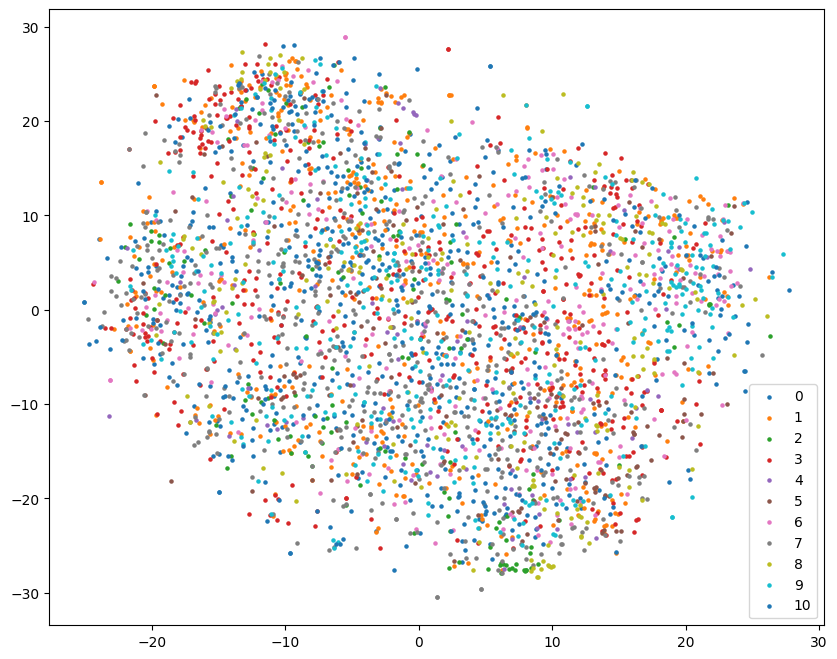

In [45]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./oscl_datasets/valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)
plot_tsne(top_module, valid_loader, device, 'Top Module t-SNE')

100%|██████████| 57/57 [00:10<00:00,  5.27it/s]


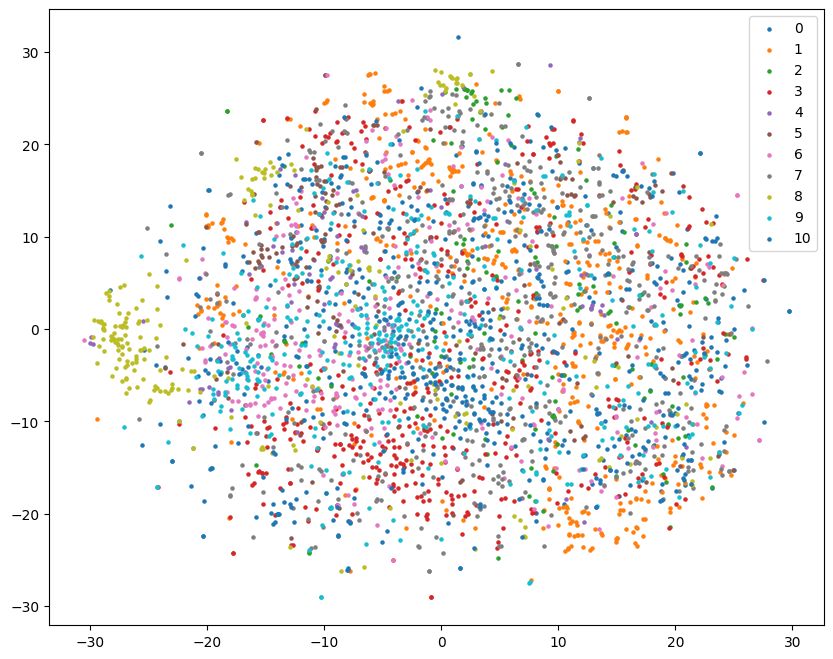

In [46]:
plot_tsne(mid_module, valid_loader, device, 'Mid Module t-SNE')

100%|██████████| 57/57 [00:11<00:00,  4.83it/s]


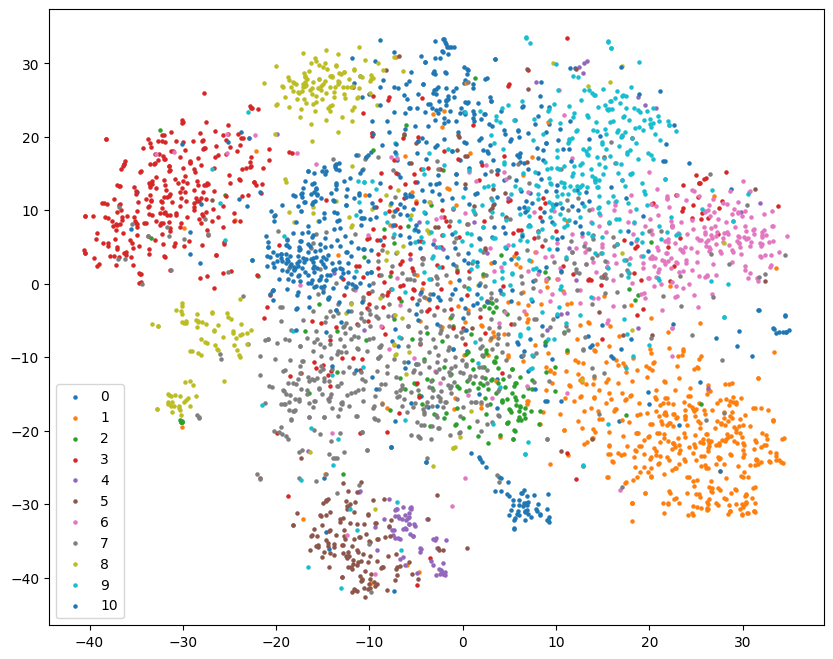

In [47]:
plot_tsne(bottom_module, valid_loader, device, 'Bottom Module t-SNE')

总结：模型越到底层，输出的`feature map`越是有意义的高维数据（降至低维进行可视化）